# Goal is to compute the temperature structure of the nebula from Q1

In [1]:
#%matplotlib notebook
import numpy as np
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const

# Exercise 2 -- start with all the same model parameters as Q1


In [2]:
# Model parameters
T_star   = 4.e4     * u.Kelvin
L_star   = 4.e39    * u.erg/u.second
n_H      = 1.e4     * u.cm**-3
T_gas    = 10000.   * u.Kelvin
alpha_B  = 2.59e-13 * u.cm**3 / u.second
sigma_H0 = 6.3e-18  * u.cm**2
E_Lya    = 10.2     * u.eV
A_Lya    = 6.265e8  * u.s**-1

Tvec = np.logspace(1,5,1000) * u.K  # logarithmically spaced vector of T from 1000 to 100,000 K


In [3]:
# Recombination rates as function of tempearture. 
# Case B. 
# fitting formula from Draine Table 14.1
# temp must be in K and have astropy unit.K
def alpha_B_from_T(temp): 
    abT = alpha_B * (temp/1e4/u.K)**(-0.833-0.035*np.log(temp/1e4/u.K))
    return abT

# Mean energy emitted by radiative recombination pre recombining electron
# fitting formula from Draine Equation 27.23. 
# temp must be in K and have astropy unit.K
def Err_B_from_T(temp): 
    errT = (0.684 - 0.0416 * np.log(temp/1e4/u.K)) * const.k_B * temp
    return errT

## Part 1 is to get the heating rate.
### since there is only one source of heating (photoionization) this part is quite simple

Draine 27.10

Gamma_PE = alpha_B * n_H * n_e * psi * k_B * T_star

where T_star is the effective temperature of the star

This needs temperature dependent alpha_B = 2.59e-13 * T4 ** (-0.833 - 0.035 ln T4) (Draine Table 14.1), from function above. 

Need \psi -- the mean energy of a photoelectron.  We could calculate this from Draine equations 27.7, or take a value of about 1.5 from Draine Table 27.1 (appropirate for about a 40,000 Kelvin star

Note in the plot that the heating rate decreases with temperature because this contains the recombination coefficient with its negative dependence on Te.

Text(0, 0.5, 'Heating rate [erg/s/cm$^3$]')

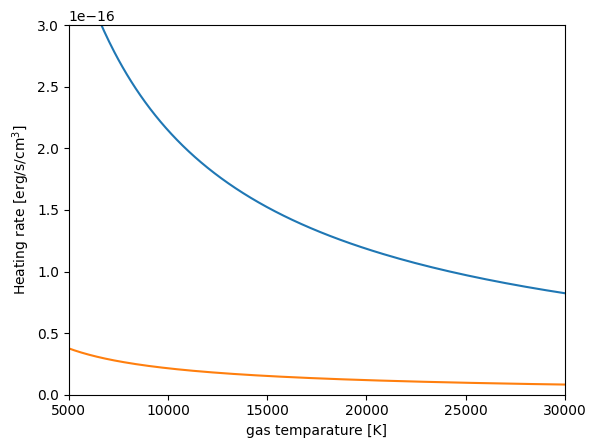

In [4]:
psi = 1.5

def get_Gamma_PE_from_Temp_Nion(temp, nion): 
    gPE = alpha_B_from_T(temp) * nion**2 * psi * const.k_B * T_star
    return gPE

def get_Gamma_PE_from_Temp_Nion_neut(temp, nion, nneut): 
    gPE = alpha_B_from_T(temp) * nion*nneut * psi * const.k_B * T_star
    return gPE

Gamma_PE = get_Gamma_PE_from_Temp_Nion(Tvec, n_H)
Gamma_PE_neut = get_Gamma_PE_from_Temp_Nion_neut(Tvec, n_H, 0.1*n_H)

plt.figure()
plt.plot(Tvec, Gamma_PE.cgs.value )
plt.plot(Tvec, Gamma_PE_neut.cgs.value )
plt.xlim([5000,30000])
plt.ylim([0,3e-16])
plt.xlabel('gas temparature [K]')
plt.ylabel(r'Heating rate [erg/s/cm$^3$]')

## Part 2 is to get the cooling rate.  There are 3 components to this
### Cooling rate by radiative recombination

Draine 27.14

Lambda_rr = alpha_B * n_p * n_e * < Err > 

alpha_B = is as above

Err is mean energy of recombing electrons.  Take Draine 27.23 approximation: 

0.684 - 0.0416 * ln(T4) * const.k_B * T

Note this is a relatively flat function across the same range of temperatures.  This is because the (a.) the recombination rate goes down in the same way as it does for Gamma_PE, but (b.) the mean energy radiated PER RECOMBINATION EVENT goes up, cancelling this in part. 

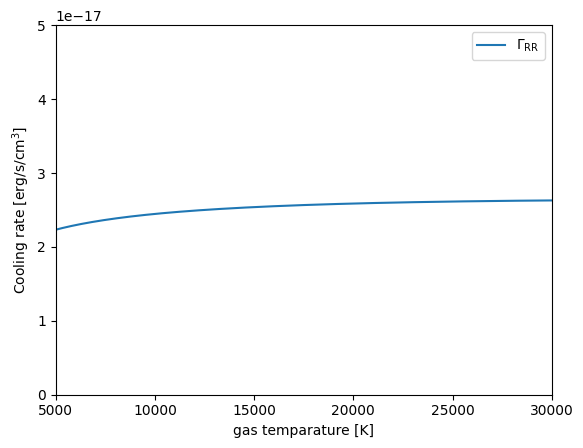

In [5]:
def get_Lambda_RR_from_Temp_Nion(temp, nion): 
    lRR = alpha_B_from_T(temp) * nion**2 * Err_B_from_T(temp)
    return lRR 

Lambda_RR = get_Lambda_RR_from_Temp_Nion(Tvec, n_H)


plt.figure()
plt.plot(Tvec, Lambda_RR.cgs.value, label=r'$\Gamma_\mathrm{RR}$' )
plt.xlim([5000,30000])
plt.ylim([0,5e-17])
plt.xlabel('gas temparature [K]')
plt.ylabel(r'Cooling rate [erg/s/cm$^3$]')
plt.legend()

## Cooling rate by free-free

Draine 10.12

Lambda_ff = 1.422e-25  * (1 + 0.44 / (1 + 0.058 (ln(T/10^5.4)^2 )) * T4^1/2 * n_p * n_e

Careful of the T/10^5.4 in one part of the equation and T in units of T4 in another

Notice how this grows much quicker than radiative recombination (because there is no worry about actually capturing the electron)

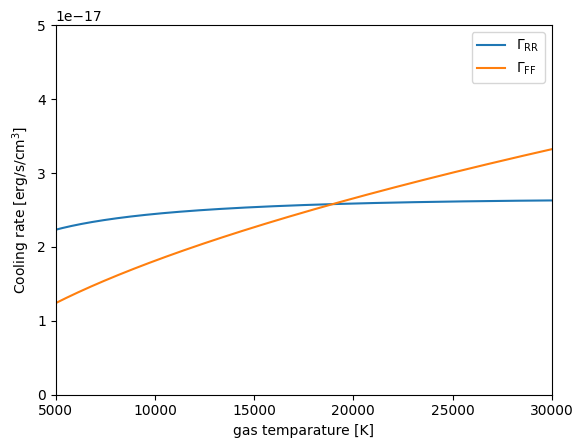

In [6]:
def get_Lambda_FF_from_Temp_Nion(temp, nion): 

    lFF = 1.422e-25*u.cm**3*u.erg/u.second * \
         (1 + 0.44 / (1 + 0.058 * np.log(temp/10**5.4/u.K)**2 ) ) * (temp/1e4/u.K)**0.5 * nion**2
    return lFF
    
Lambda_FF = get_Lambda_FF_from_Temp_Nion(Tvec, n_H)



# units placed on the prefactor 

plt.figure()
plt.plot(Tvec, Lambda_RR.cgs.value, label=r'$\Gamma_\mathrm{RR}$' )
plt.plot(Tvec, Lambda_FF.cgs.value, label=r'$\Gamma_\mathrm{FF}$' )
plt.xlim([5000,30000])
plt.ylim([0,5e-17])
plt.xlabel('gas temparature [K]')
plt.ylabel(r'Cooling rate [erg/s/cm$^3$]')
plt.legend()

## Cooling rate by collissional excitation

Lambda_ce = $n_2  A_{21}  h\nu$

Where $n_2$ = number density of H atoms in $n=2$ first excited state. 

$A_21$ = Einstein A coefficient for Lya; $h \nu = 10.2$ eV. 

Then we need the rate coefficient from collision strength.  Draine appendix I, eq 9

For the dexcitation rate coefficient, use : $k_{21} = \langle \sigma v \rangle = \frac{h^2}{(2 \pi m_e)^{3/2}} \times \frac{1}{(k_B T)^{1/2}} \times \frac{\Omega_{21}}{g_2}$

Using the principle of detailed balance (Draine 3.21) we get the inverse: $k_{12} = k_{21} \ \frac{g_2}{g_1} \times exp\left(\frac{-h \nu}{kT}\right)$

A equilibrium, collisions excitatation rate balances the collisional deexcitation rate + the rate of spontaneous decays

$n_e  n_{H0_1}  k_{12} =    n_e  n_{H0_2}  k_{21} + n_{H0_2}  A_{21}   =   n_{H0_2} (n_e  k_{21} + A_{21})$
 
$n_{H0_1} = n_{H0} - n_{H0_2}$

Thus
$n_{H0_2} = .... = \frac{ \frac{g_2}{g_1} k_{21} \exp\left(-\frac{E_{Lya}}{kT}\right) } { k_{21} + \frac{A_{21}}{n_e} + \frac{g_2}{g_1} k_{21} \exp\left(-\frac{E_{Lya}}{kT}\right) }$ 


In [7]:
g2 = 8
g1 = 4

Omega_21 = 0.45 # Osterbrock table 3.12.  Weakly temperature dependent.  take average value 

# Draine Appendix I, equation 9
def kul_from_T(temp, Omega_ul, g_u): 
    kul = const.h**2 / (2 * np.pi * const.m_e)**(3/2) / (const.k_B * temp)**(1/2) * Omega_ul / g_u 
    return kul 

def n_H0_2_from_nH0_ne_T(numH0, nume, temp): 
    k21   = kul_from_T(temp, Omega_21, g2 )
    expon = np.exp(-E_Lya / const.k_B / temp)
    num   = (g2/g1) * numH0 * k21* expon
    den   =  k21 + A_Lya/nume + (g2/g1)*k21*expon
    #print (num[0].decompose())
    #print (den[0].decompose())
    return num/den

def get_Lambda_CE_from_Temp_2N(temp, nume, numn):   #numn = numneutral 

    n2 = n_H0_2_from_nH0_ne_T(numn, nume, temp)# * A_Lya * E_Lya
    lCE = n2 * A_Lya * E_Lya
    return lCE

Lambda_CE = get_Lambda_CE_from_Temp_2N(Tvec, n_H, 1e-1*u.cm**-3)

# put it all together

Note that N_H is used in all cases here as an illustration.  in reality n_H, n_e, and n_p will be taken independently. 

Text(0, 0.5, 'rate coeffcieints (erg / s / cm$^3$)')

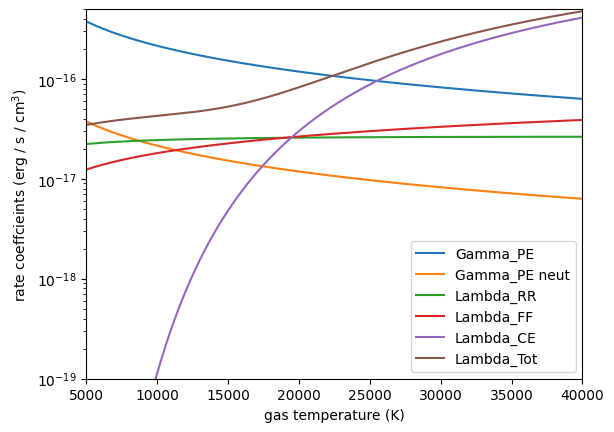

In [8]:


# note we have put in a very high H0 density here to visualize the collisional cooling rate. 
# that's only approapriate at the boundary region

Gamma_PE      = get_Gamma_PE_from_Temp_Nion(Tvec, n_H)
Gamma_PE_neut = get_Gamma_PE_from_Temp_Nion_neut(Tvec, n_H, 0.1*n_H)
Lambda_RR     = get_Lambda_RR_from_Temp_Nion(Tvec, n_H)
Lambda_FF     = get_Lambda_FF_from_Temp_Nion(Tvec, n_H)
Lambda_CE     = get_Lambda_CE_from_Temp_2N(Tvec, n_H, .001 * n_H)
Lambda_Tot    = Lambda_RR+Lambda_FF+Lambda_CE

plt.figure()
plt.plot(Tvec, Gamma_PE.cgs.value  , label='Gamma_PE' )
plt.plot(Tvec, Gamma_PE_neut.cgs.value  , label='Gamma_PE neut' )
plt.plot(Tvec, Lambda_RR.cgs.value , label='Lambda_RR' )
plt.plot(Tvec, Lambda_FF.cgs.value , label='Lambda_FF' )
plt.plot(Tvec, Lambda_CE.cgs.value , label='Lambda_CE' )
plt.plot(Tvec, Lambda_Tot.cgs.value, label='Lambda_Tot' )
plt.legend()
plt.semilogy()
plt.xlim([5000,40000])
plt.ylim([1.e-19,5e-16])
plt.xlabel('gas temperature (K)')
plt.ylabel(r'rate coeffcieints (erg / s / cm$^3$)')

# learn to solve for the intersection
result looks, by eye, like the interstion between blue and purple curves in the above plot

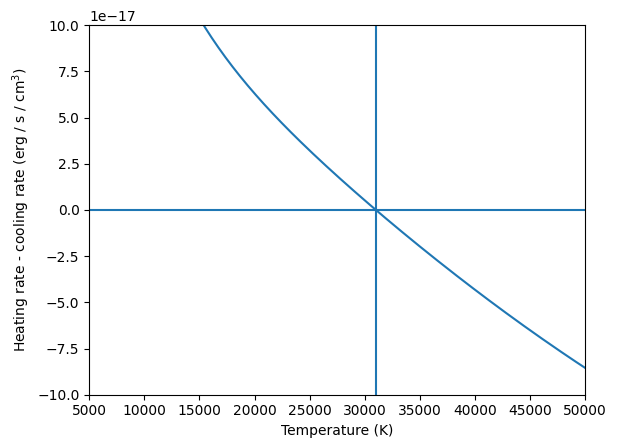

In [9]:
def get_Heat_minus_Cool( nelectron, nneutral, temperature  ): 

    heat_PE  = get_Gamma_PE_from_Temp_Nion(temperature*u.K, nelectron*u.cm**-3).cgs.value
    #heat_PE  = get_Gamma_PE_from_Temp_Nion_(temperature*u.K, nelectron*u.cm**-3, nneutral*u.cm**-3).cgs.value
    cool_RR  = get_Lambda_RR_from_Temp_Nion(temperature*u.K, nelectron*u.cm**-3).cgs.value
    cool_FF  = get_Lambda_FF_from_Temp_Nion(temperature*u.K, nelectron*u.cm**-3).cgs.value
    cool_CE  = get_Lambda_CE_from_Temp_2N  (temperature*u.K, nelectron*u.cm**-3, nneutral*u.cm**-3).cgs.value
    cool_Tot = cool_RR+cool_FF+cool_CE
    diff     = heat_PE - cool_Tot
    
    return diff

from scipy.stats import linregress


d = get_Heat_minus_Cool( 1e4,  1, Tvec.value )

if d.min() * d.max() >=0: 
    tb = -1. # return a negative number to indicate differnce function cannot cross zero
    print ('solution not found')
else: 
    imin = np.absolute(d).argmin()

    tfitvec = Tvec[imin-5:imin+5]
    dfitvec = d   [imin-5:imin+5]
    fit = linregress(dfitvec, tfitvec)
    
    plt.figure()
    plt.plot(Tvec, d)
    plt.axhline(0)
    plt.axvline(fit.intercept)
    plt.axis([5000,50000,-1e-16,1e-16])
    plt.xlabel("Temperature (K)")
    plt.ylabel(r"Heating rate - cooling rate (erg / s / cm$^3$)")

# Everything seems to behave, so load the data from question 1a
this will take a long time to run.  Extra credit will be given for more elegant solutions than this! 


In [10]:
stardat = np.loadtxt('Q1A_star.txt')
rad = stardat[:,0]
y   = stardat[:,1]
x   = stardat[:,2]
tau = stardat[:,3]

In [11]:
Tneb = np.zeros_like(y)

irad = int(len(y)*0.665)

for irad in range(len(y)-1,0, -1): 
    ionfrac  = x[irad]
    nion     =    ionfrac  * n_H.cgs.value
    nneutral = (1-ionfrac) * n_H.cgs.value
    
    if irad%10000==0:
        print (y[irad], ionfrac, nion, nneutral)
        
    d = get_Heat_minus_Cool( nion,  nneutral, Tvec.value )
    if d.min() * d.max() >=0: 
        
        # return a negative number to indicate difference function cannot cross zero
        Tneb[irad] = -1 
    else: 
        imin = np.absolute(d).argmin()
        
        tfitvec = Tvec[imin-5:imin+5]
        dfitvec = d   [imin-5:imin+5]
        fit = linregress(dfitvec, tfitvec)
        
        Tneb[irad] = fit.intercept
        
        #print (Tneb[irad])
        #plt.figure()
        #plt.plot(Tvec, d)
        #plt.axhline(0)
        #plt.axvline(fit.intercept)
        #plt.axis([5000,50000,-1e-16,1e-16])

/home/mhaye/anaconda3/envs/stenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.15535053 0.0 0.0 10000.0
0.96279211 0.999008955 9990.08955 9.910450000000237
0.770233688 0.999873823 9998.73823 1.2617699999994958
0.577675266 0.999952242 9999.52242 0.4775800000000885
0.385116844 0.999981827 9999.81827 0.18172999999954698
0.192558422 0.999995685 9999.95685 0.04314999999976976


In [12]:
Tneb

array([ 0.00000000e+00,  3.89999588e+04,  3.89999588e+04, ...,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00])

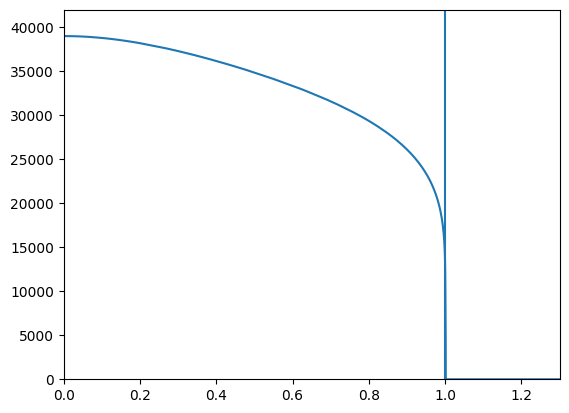

In [13]:
plt.figure()
plt.plot(y[1:], Tneb[1:])
plt.axis([0,1.3,0,42000])
plt.axvline(1.)
# increases inwards 
# becomes asymptotically close to T_star
# becomes flat 
# sharp transition at stromgren radius where n_e becomes ~0.

# Numerical issues? 

(0.0, 0.002, 38000.0, 40000.0)

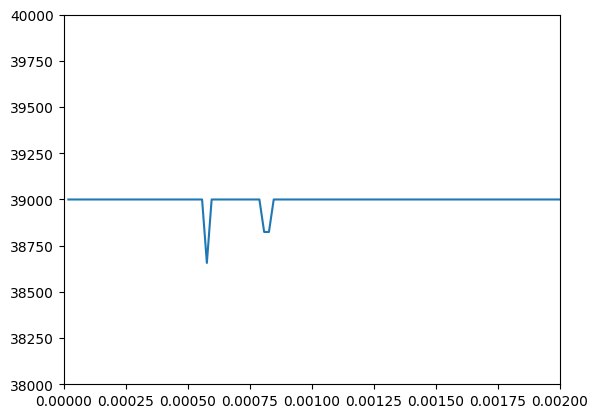

In [14]:
plt.figure()
plt.plot(y[1:], Tneb[1:])
plt.axis([0,.002,38000,40000])
# hot gas near T_star.  cooling rates are very flat with temperatue

(1e-19, 5e-16)

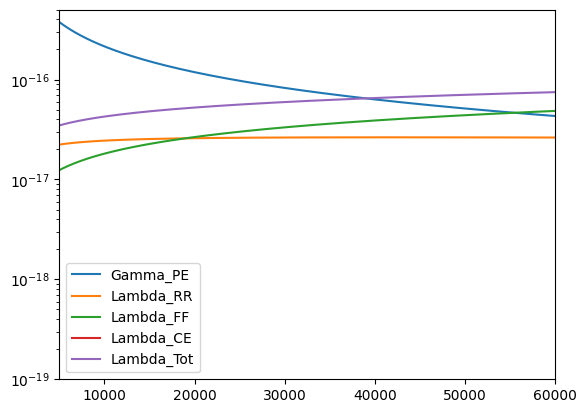

In [15]:
# take the first point in our real array.
ionfrac   = x[1]
nelectron =    ionfrac  * n_H.cgs.value
nneutral  = (1-ionfrac) * n_H.cgs.value

heat_PE  = get_Gamma_PE_from_Temp_Nion (Tvec, nelectron*u.cm**-3).cgs.value
cool_RR  = get_Lambda_RR_from_Temp_Nion(Tvec, nelectron*u.cm**-3).cgs.value
cool_FF  = get_Lambda_FF_from_Temp_Nion(Tvec, nelectron*u.cm**-3).cgs.value
cool_CE  = get_Lambda_CE_from_Temp_2N  (Tvec, nelectron*u.cm**-3, nneutral*u.cm**-3).cgs.value
cool_Tot = cool_RR+cool_FF+cool_CE

plt.figure()
plt.plot(Tvec, heat_PE , label='Gamma_PE' )
plt.plot(Tvec, cool_RR , label='Lambda_RR' )
plt.plot(Tvec, cool_FF , label='Lambda_FF' )
plt.plot(Tvec, cool_CE , label='Lambda_CE' )
plt.plot(Tvec, cool_Tot, label='Lambda_Tot' )
plt.legend()
plt.semilogy()
plt.xlim([5000,60000])
plt.ylim([1.e-19,5e-16])

Of course, I do not know why YOU experience numerical issues.

But in my case the numerical issues arise because of the
flatness of the cooling function.  And the ridiculous (but fast) nature of my solver.

A steeper cooling term with temperature occurs when collisional terms become important.  In the below I produce the same plot with n_neutral set to 5 cm-3. 

Notice how the temperature is also very much reduced by this artifiical collisional term.  this sets up the answer for 3b

(1e-19, 5e-16)

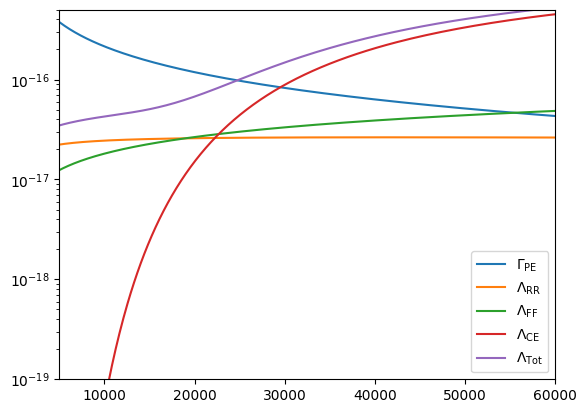

In [16]:
# take the first point in our real array.
ionfrac   = x[1]
nelectron =    ionfrac  * n_H.cgs.value
nneutral  = (1-ionfrac) * n_H.cgs.value

heat_PE  = get_Gamma_PE_from_Temp_Nion (Tvec, nelectron*u.cm**-3).cgs.value
cool_RR  = get_Lambda_RR_from_Temp_Nion(Tvec, nelectron*u.cm**-3).cgs.value
cool_FF  = get_Lambda_FF_from_Temp_Nion(Tvec, nelectron*u.cm**-3).cgs.value
cool_CE  = get_Lambda_CE_from_Temp_2N  (Tvec, nelectron*u.cm**-3, 5*u.cm**-3).cgs.value
cool_Tot = cool_RR+cool_FF+cool_CE

plt.figure()
plt.plot(Tvec, heat_PE , label=r'$\Gamma _\mathrm{PE}$' )
plt.plot(Tvec, cool_RR , label=r'$\Lambda_\mathrm{RR}$' )
plt.plot(Tvec, cool_FF , label=r'$\Lambda_\mathrm{FF}$' )
plt.plot(Tvec, cool_CE , label=r'$\Lambda_\mathrm{CE}$' )
plt.plot(Tvec, cool_Tot, label=r'$\Lambda_\mathrm{Tot}$' )
plt.legend()
plt.semilogy()
plt.xlim([5000,60000])
plt.ylim([1.e-19,5e-16])